### Augmentations

Most of the standard Geometric 2D augmentations can be composed from affine matrices.

![image](../nb_data/affine.png)

Lets load an image with bbox and keypoint labels

In [50]:
import cv2
import yaml
from PIL import Image

# Read image
img = cv2.imread('../nb_data/augmentation_data.png')
print(f"Image size = width:{img.shape[1]} pixels / height:{img.shape[0]} pixels")

# Read labels
labels = yaml.safe_load(open('../nb_data/augmentation_data_labels.yml'))['labels']
print(labels)

Image size = width:599 pixels / height:464 pixels
{'wickets': {'x1': 253, 'y1': 250, 'x2': 315, 'y2': 434}, 'bat': {'x1': 372, 'y1': 18, 'x2': 482, 'y2': 69}, 'wicket_camera': {'x': 288, 'y': 386}, 'r_eye': {'x': 314, 'y': 108}, 'l_eye': {'x': 329, 'y': 103}}


Plot labels

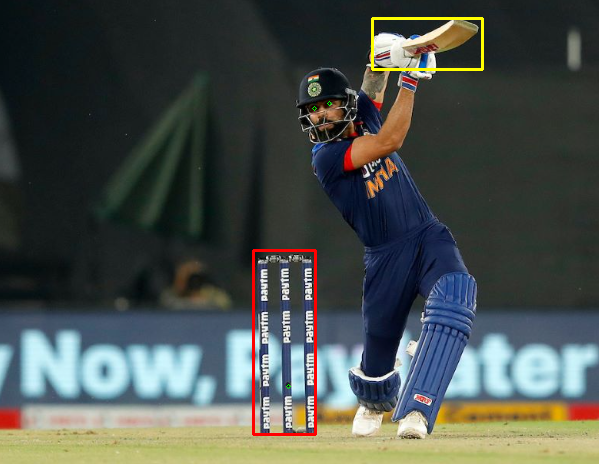

In [49]:
#Wickets
image = cv2.rectangle(img, (labels['wickets']['x1'], labels['wickets']['y1']),\
    (labels['wickets']['x2'], labels['wickets']['y2']), (0, 0 , 255), 2)
#Bat
image = cv2.rectangle(img, (labels['bat']['x1'], labels['bat']['y1']),\
    (labels['bat']['x2'], labels['bat']['y2']), (0, 255 , 255), 2)
# Wicket camera
image = cv2.circle(img, (labels['wicket_camera']['x'], labels['wicket_camera']['y']), \
    2, (0, 255, 0), 1)
# l_eye camera
image = cv2.circle(img, (labels['l_eye']['x'], labels['l_eye']['y']), \
    2, (0, 255, 0), 1)
# r_eye camera
image = cv2.circle(img, (labels['r_eye']['x'], labels['r_eye']['y']), \
    2, (0, 255, 0), 1)

pil_image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
display(pil_image)

### Affine Matrix Calculator class

This class composes a sequence of rotation, translation, scaling and shearing into one matrix.

In [68]:
from typing import Any
import numpy as np

class AffineMatrixCalculator:

    def __init__(self):
        pass

    def __call__(self, rotation=0., translation=(0., 0.) ,scale=(1., 1.), shear=(0., 0.)):
        self.M_R = self.getRotationMatrix(rotation)
        self.M_t = self.getTranslationMatrix(translation)
        self.M_Sc = self.getScalingMatrix(scale)
        self.M_Sh = self.getShearingMatrix(shear)
        return self.M_t @ self.M_R @ self.M_Sc @ self.M_Sh

    @staticmethod
    def getRotationMatrix(deg):
        angle = np.radians(deg)
        R=np.array([[np.cos(angle), -np.sin(angle), 0],\
                    [np.sin(angle), np.cos(angle), 0],\
                    [0, 0, 1]])
        return R

    @staticmethod
    def getTranslationMatrix(trans):
        M = np.eye(3)
        M[0, 2] = trans[0]
        M[1, 2] = trans[1]
        return M

    @staticmethod
    def getScalingMatrix(s):
        M = np.eye(3)
        M[0, 0] = s[0]
        M[1, 1] = s[1]
        return M

    @staticmethod
    def getShearingMatrix(s):
        M = np.eye(3)
        M[0, 1] = s[0]
        M[1, 0] = s[1]
        return M

A = AffineMatrixCalculator()
M = A(rotation=10., translation=(0.1, 0.2), scale=(0.7, 0.9), shear=(0.02, 0.05))
print(M)

[[ 0.68155126 -0.14249605  0.1       ]
 [ 0.16587007  0.88875805  0.2       ]
 [ 0.          0.          1.        ]]


Warping the image with the M matrix

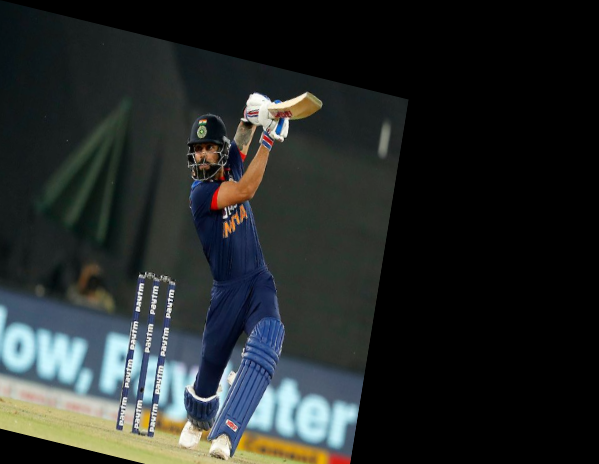

In [69]:
aug_img = cv2.warpAffine(img, M[:2, :], (img.shape[1],img.shape[0]))
pil_image = Image.fromarray(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
display(pil_image)

Warping the labels

In [80]:
aug_labels = {}
w = int(abs(labels['wickets']['x1'] - labels['wickets']['x2']))
h = int(abs(labels['wickets']['y1'] - labels['wickets']['y2']))
wickets = np.array([[labels['wickets']['x1'], labels['wickets']['y1'], 1.], \
                    [labels['wickets']['x1']+w, labels['wickets']['y1'], 1.], \
                    [labels['wickets']['x1']+w, labels['wickets']['y1']+h, 1.], \
                    [labels['wickets']['x1'], labels['wickets']['y1']+h, 1.]])

print(wickets)
augmented_wickets = (M @ wickets.T).T

# circumscribed bbox
augmented_wickets
print(augmented_wickets)


[[253. 250.   1.]
 [315. 250.   1.]
 [315. 434.   1.]
 [253. 434.   1.]]
[[136.90845572 264.35464158   1.        ]
 [179.16463378 274.63858612   1.        ]
 [152.94536033 438.17006773   1.        ]
 [110.68918227 427.88612319   1.        ]]


In [78]:
aug_img = cv2.polylines(aug_img, augmented_wickets.tolist(), (0, 0, 255), 2)

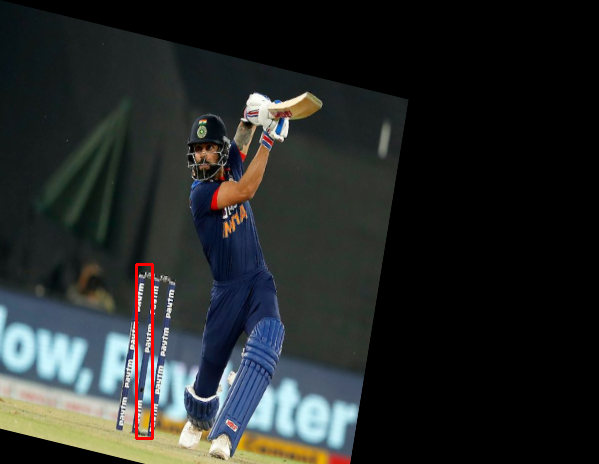

In [79]:
pil_image = Image.fromarray(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
display(pil_image)